In [1]:
import javalang
import json
import re
import time
import random
import nltk
nltk.download('punkt')
import numpy as np
import pickle
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import seaborn as sns

MODE = "simple"  #normal or simple or SBT
BATCH_SIZE = 10
EMBEDDING_DIM = 256
UNITS = 256

[nltk_data] Downloading package punkt to /home/yurong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Function declaration

In [2]:
'''
Function：
    Input the code token list, comment string，and return whether it's invalid
The rule of valid method:
    1. code token size <= 100
    2. One-sentence-comment（I hope model generate only one sentence.
       If training data consist multi-sentence comment, the effect will be bad and the first sentence only can not
       properly describe the functionality of the method）

PS: I regard "tester", "setter", "getter" and "constructor" as valid method
'''
def is_invalid_method(code, nl):   
    tokens_parse = javalang.tokenizer.tokenize(code)
    token_len = len(list(tokens_parse))
    
    if token_len > 350 or len(code.split('\n')) > 40:
        return True
    if len(nl.split('.')) != 1 or len(nltk.word_tokenize(nl)) > 30:
        return True
    else :
        return False
    
    
'''
Function: 
    Input the root of AST and the deep of the tree, 
    it will filter the null value and return the list of SBT (structural-based travesal) and print the tree structure
'''
def parse_tree(root, deep):
    seq = []
    seq.extend(['(', str(root).split('(')[0]])
    #print('\t'*(deep)+str(root).split('(')[0])    # show node name
    if not hasattr(root, 'attrs'):  # error-handling
        return []
    for attr in root.attrs:
        if eval('root.%s' % attr) in [None, [], "", set(), False]:    # filter the null attr
            continue
        elif isinstance(eval('root.%s' % attr), list):
            x = eval('root.%s' % attr)
            if not all(elem in x for elem in [None, [], "", set(), False]):    # if not all elements in list are null
                seq.extend(['(',attr])
                #print('\t'*(deep+1)+attr)
                #deep += 1
                for i in eval('root.%s' % attr):    # recursive the list
                    if i is None or isinstance(i, str):    # perhaps it has None value in the list
                        continue
                    #deep += 1
                    seq.extend(parse_tree(i, deep))
                    
                    #deep -= 1
                #deep -= 1
                seq.extend([')',attr])
        elif 'tree' in str(type(eval('root.%s' % attr))):    #if the attr is one kind of Node, recursive the Node
            seq.extend(['(',attr])
            #print('\t'*(deep+1)+attr)
            #deep += 2
            seq.extend(parse_tree(eval('root.%s' % attr), deep))
            #deep -= 2
            seq.extend([')',attr])
        else:
            seq.extend(['(','<'+str(attr)+'>_'+str(eval('root.%s' % attr)),')','<'+str(attr)+'>_'+str(eval('root.%s' % attr))])
            #exec("print('\t'*(deep+1)+attr+': '+str(root.%s))" % attr)    #it must be normal attribute
    seq.extend([')', str(root).split('(')[0]])
    return seq


'''
Usage:
    1. "camelCase" -> ["camel", "Case"]
    2. "snake_case" -> ["snake", "_", "case"]
    3. "normal" -> ["normal"]
'''
def split_identifier(id_token):
    if  "_" in id_token:
        return id_token.split("_")
    elif id_token != id_token.lower() and id_token != id_token.upper():
        matches = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', id_token)
        return [m.group(0) for m in matches]
    else:
        return [id_token]

    
    
'''
Usage:
    1. input the list of train, test, valid dataset
    2. filter the dataset, split it to train, test set and save as the smaller dataset.
    3. return the amount of the data from smaller datasets.
Example:
    filter_dataset(['./data/train.json', './data/test.json'], './data')
Note:
    The filter method is different from the method in DeepCom, because I have no idea how DeepCom did.
    It doesn't make sense that DeepCom could filter so many data via the method mentioned in its paper.
'''
def filter_dataset(path_list, save_path):
    
    inputs = []
    for path in path_list:
        input_file = open(path)
        inputs.extend(input_file.readlines())
        input_file.close()
    outputs = []
    
    if not os.path.exists(save_path):
        os.makedirs(save_path)
        
    output_train_file = open(save_path+'/simplified_train.json', "w")
    output_test_file = open(save_path+'/simplified_test.json', "w")
    
    print('Original total: '+str(len(inputs)))
    for pair in inputs:
        pair = json.loads(pair)
        if is_invalid_method(pair['code'], pair['nl']):
            continue
        outputs.append(json.dumps(pair))

    random.shuffle(outputs)
    print('Final total: '+str(len(outputs)))
    print('Data shuffle complete')
    train_index = int(len(outputs)*0.9)
    test_index = int(len(outputs)-1)
    train_output = outputs[:train_index]
    test_output = outputs[train_index+1:test_index]
    
    for row in train_output:
        output_train_file.write(row+'\n')
    output_train_file.close()
    print('simplified train data finish writing')
    for row in test_output:
        output_test_file.write(row+'\n')
    output_test_file.close()
    print('simplified test data finish writing')


    return len(train_output), len(test_output)


'''
Parameters:
    path: the path of the data you want to read
    code_voc: code vocabulary, the data type is list
    comment_voc: comment vocabulary, the data type is list
    mode: "simple" or "normal"
Return values:
    code_tokens, comment_tokens: 2-dimension list, store the code and comment into list, snippet by snippet
    code_voc, comment_voc: the all vocabularies in the file of the path, data type is list
Note:
    It hasn't used SBT in DeepCom.
TODO:
    Change the rare words in comments into other common words via pre-trained embedding
'''
def readdata(path, code_voc, comment_voc, mode):
    input_file = open(path)
    inputs = input_file.readlines()

    code_tokens = []          # code_tokens = ['<START>', '<Modifier>', 'public', '<Identifier>',....]
    comment_tokens = []       # comment_tokens = []

    start = time.time()
    
    #=============== extract comment part of the snippet ==========================
    print("comment tokenizing...")
    for index, pair in enumerate(inputs):
        pair = json.loads(pair)
        tokens = nltk.word_tokenize(pair['nl'])
        tokens.append('<END>')
        comment_tokens.append(tokens)
        for x in tokens:
            if x not in comment_voc:
                comment_voc.append(x)
    
    # =============== extract the code part of the snippet =========================
    if mode=="SBT":
        token_count = dict()

        # count the code tokens
        print("counting tokens...")
        for index, pair in enumerate(inputs):
            if index%20000 == 0 and index != 0:
                print(index)
            pair = json.loads(pair)
            parsed_inputs = code_tokenize(pair['code'], mode)
            
            inputs[index] = parsed_inputs
            if len(parsed_inputs) == 0:  # error-handling due to dirty data when SBT mode
                continue
            
            for x in parsed_inputs:
                if x not in token_count:
                    token_count[x] = 1
                else:
                    token_count[x] += 1

        # select most frequency 30000 voc
        typename = ['<modifiers>', '<member>', '<value>', '<name>', '<operator>', '<qualifier>']
        code_voc.extend(typename)
        for w in sorted(token_count, key=token_count.get, reverse=True)[:30000-len(code_voc)]:
            code_voc.append(w) 
            
        print('token processing...')
        # <SimpleName>_extractFor -> <SimpleName>, if <SimpleName>_extractFor is outside 30000 voc
        for index, parsed_inputs in enumerate(inputs):
            if index%20000 == 0 and index != 0:
                print(index)
            if len(parsed_inputs) == 0:  
                continue
            for index2 in range(len(parsed_inputs)):
                if parsed_inputs[index2] not in code_voc:
                    tmp = parsed_inputs[index2].split('_')
                    if len(tmp) > 1 and tmp[0] in typename:
                        parsed_inputs[index2] = tmp[0]
                    else:
                        parsed_inputs[index2] = "<UNK>"
            code_tokens.append(parsed_inputs)
            

    elif mode == "simple" or mode == "normal":
        print("code tokenizing...")
        for index, pair in enumerate(inputs):
            if index%20000 == 0 and index != 0:
                print(index)
            pair = json.loads(pair)
            parsed_inputs = code_tokenize(pair['code'], mode)

            for x in parsed_inputs:
                if x not in code_voc:
                    code_voc.append(x)
            code_tokens.append(parsed_inputs)
        

    print('readdata:')
    print('\tdata amount: '+str(len(code_tokens)))
    print('\trun time: '+str(time.time()-start))

    input_file.close()
    return code_tokens, comment_tokens, code_voc, comment_voc


'''
Usage:
    Transform the token to the index in vocabulary
    ['<START>', '<Modifier>', 'public', ..., '<Separator>', ';', '<Separator>', '}', '<END>']
    => [0, 7, 8, ..., 14, 29, 14, 30, 1]
Parameter data type: 
    2-dimension list
Return data type:
    2-dimension list
'''
def token2index(lst, voc):
    for index, seq in enumerate(lst):
        seq_index = []
        for token in seq:
            seq_index.append(voc.index(token))
        lst[index] = seq_index
    return lst


'''
Parameters:
    lst: the list of sequences to be padded
    pad_data: the value you want to pad
Return type:
    numpy array
'''
def pad_sequences(lst, pad_data):
    maxlen = max(len(x) for x in lst)
    for index, seq in enumerate(lst):
        lst[index].extend([pad_data] * (maxlen-len(seq)))
    return np.array(lst)

'''
Parameters:
    x: the list of data
    batch_sz: batch size
Return shape:
    [None, batch_sz, None]
Example:
    a = [1,2,3,4,5,6,7,8,9,10]
    a = getBatch(x=a, batch_sz=3)
    a
    ---output---
    [[1,2,3], [4,5,6], [7,8,9]]
'''
def getBatch(x, batch_sz):
    dataset = []
    while(len(x)>=batch_sz):
        dataset.append(x[:batch_sz])
        x = x[batch_sz:]
    if type(x) == np.ndarray:
        return np.array(dataset)
    elif type(x) == list:
        return dataset
    
def ngram(words, n):
    return list(zip(*(words[i:] for i in range(n))))


#  bleu4 (n=4)
def bleu(true, pred, n):
    true = nltk.word_tokenize(true)
    pred = nltk.word_tokenize(pred)
    c = len(pred)
    r = len(true)
    bp = 1. if c > r else np.exp(1 - r / (c + 1e-10))
    score = 0
    
    for i in range(1, n+1):
        true_ngram = set(ngram(true, i))
        pred_ngram = ngram(pred, i)
        if len(true_ngram)==0 or len(true_ngram)==0:
            break
        length = float(len(pred_ngram)) + 1e-10
        count = sum([1. if t in true_ngram else 0. for t in pred_ngram])
        score += math.log(1e-10 + (count / length))
    score = math.exp(score / n)  #n就是公式的Wn
    bleu = bp * score
    return bleu


def evaluate(code, encoder, decoder, code_voc, comment_voc, max_length_inp, max_length_targ, mode):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    inputs = code_tokenize(code, mode)
    
    if mode=="simple" or mode=="normal":
        for index, token in enumerate(inputs):
            if token not in code_voc:
                inputs[index] = code_voc.index('<UNK>')
            else:
                inputs[index] = code_voc.index(token)
                
    elif mode=="SBT":
        typename = ['<modifiers>', '<member>', '<value>', '<name>', '<operator>', '<qualifier>']
        for index, token in enumerate(inputs):
            if token not in code_voc:
                tmp = token.split('_')
                if len(tmp) > 1 and tmp[0] in typename:
                    inputs[index] = code_voc.index(tmp[0])
                else:
                    inputs[index] = code_voc.index("<UNK>")
            else:
                inputs[index] = code_voc.index(token)
    
    
    inputs += [code_voc.index('<PAD>')] * (max_length_inp - len(inputs))
    inputs = np.array(inputs)
    inputs = tf.expand_dims(inputs, 0)
    
    result = ''
    
    hidden_h, hidden_c = tf.zeros((1, UNITS)), tf.zeros((1, UNITS))
    hidden = [hidden_h, hidden_c]
    enc_output, enc_hidden_h, enc_hidden_c = encoder(inputs, hidden)
    dec_hidden = [enc_hidden_h, enc_hidden_c]
    
    dec_input = tf.expand_dims([comment_voc.index('<START>')], 1)       
    
    for t in range(max_length_targ):
        predictions, dec_hidden_h, dec_hidden_c, attention_weights = decoder(dec_input, dec_hidden, enc_output)
        dec_hidden = [dec_hidden_h, dec_hidden_c]
        
        # storing the attention weigths to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        if comment_voc[predicted_id] == '<END>':
            return result, code, attention_plot
        
        result += comment_voc[predicted_id] + ' '
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, code, attention_plot


# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    sns.set()
    fig, ax = plt.subplots(figsize=(20,10)) 
    sns.heatmap(attention, xticklabels=sentence, yticklabels=predicted_sentence, ax=ax)
    

def translate(code, encoder, decoder, code_voc, comment_voc, max_length_inp, max_length_targ, mode):
    result, code, attention_plot = evaluate(code, encoder, decoder, code_voc, comment_voc, max_length_inp, max_length_targ, mode)
    return result

def code_tokenize(code, mode):
    inputs = []
    if mode =="simple":
        tokens_parse = javalang.tokenizer.tokenize(code)
        for token in tokens_parse:    # iterate the tokens of the sentence
            token = str(token).split(' ')
            splitted_id = split_identifier(token[1].strip('"'))    # split the camelCase and snake_case
            inputs.extend(splitted_id)
    elif mode == "normal":
        tokens_parse = javalang.tokenizer.tokenize(code)
        for token in tokens_parse:    # iterate the tokens of the sentence
            token = str(token).split(' ')
            splitted_id = split_identifier(token[1].strip('"'))    # split the camelCase and snake_case
            temp = ['<'+token[0]+'>']    # token[0] is token type, token[1] is token value
            temp.extend(splitted_id)
            inputs.extend(temp)
            
    elif mode == "SBT":
        tree = javalang.parse.parse('class aa {'+code+'}')
        _, node = list(tree)[2]    # 前兩個用來篩掉class aa{ }的部分
        inputs = parse_tree(node, 0)
        if len(inputs) == 0:   # error-handling due to dirty data
            return []

    inputs.insert(0, '<START>')
    inputs.append('<END>')
    
    return inputs


'''
用途：把一個二維的array做機率正規化
例如：[[3,4,5],[1,2,3]] -> [[0.25, 0.33, 0.416], [0.167, 0.333, 0.5]]
'''
def distribution(arr):
    new_arr = []
    for i in arr:
        tmp = []
        total = sum(i)
        for x in i:
            tmp.append(x/total)
        new_arr.append(tmp)
    return np.array(new_arr)


## Analysis the big dataset

total data: 588108
avg loc : 12.934027423534452
max loc : 2860

Level 1: 0.67
Level 2: 0.86
Level 3: 0.92
Level 4: 0.95
Level 5: 0.97
Level 6: 0.98
Level 7: 1.0


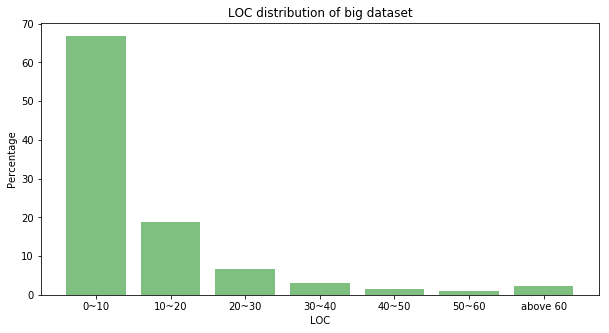

In [95]:
inputs = []
for path in ['./data/train.json', './data/test.json', './data/valid.json']:
    input_file = open(path)
    inputs.extend(input_file.readlines())
    input_file.close()

avgloc = 0
locLevel = {'1':0, '2':0, '3':0, '4':0, '5':0, '6':0, '7':0}  # loc level {0~10, 10~20, ..., 50~60, 60up}
maxloc = 0
maxkey = 0

print('total data: ' + str(len(inputs)))
for key, pair in enumerate(inputs):
    pair = json.loads(pair)
    loc = len(pair['code'].split('\n'))
    avgloc += loc
    if loc >= 60:
        locLevel['7'] += 1
    else:
        locLevel[str(math.ceil(loc/10))] += 1
    if loc > maxloc:
        maxloc = loc
        maxkey = key

avgloc = avgloc/len(inputs)

print('avg loc : '+str(avgloc))
print('max loc : '+str(maxloc),end='\n\n')


cnt = 0
percent_cnt = []
percent_cnt2 = []
for i in range(7):
    cnt += locLevel[str(i+1)]
    percent_cnt.append(round(cnt/len(inputs), 2))
    percent_cnt2.append((locLevel[str(i+1)]/len(inputs))*100)
    print('Level '+str(i+1)+': '+str(round(cnt/len(inputs), 2)))


objects = ('0~10', '10~20', '20~30', '30~40', '40~50', '50~60', 'above 60')
y_pos = np.arange(len(objects))

plt.figure(figsize=(10,5))
plt.bar(y_pos, percent_cnt2, color="g", align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xlabel('LOC')
plt.ylabel('Percentage')
plt.title('LOC distribution of big dataset')

plt.show()

## Prune the original big dataset into simpler and better dataset
* #### Size of training set, testing set and valid set ->  (81932, 10241, 10241)
* #### If you already have "simplified_train.json", "simplified_test.json" and "simplified_valid.json", then you can skip this code cell.

In [3]:
filter_dataset(['./data/train.json', './data/test.json'], './simplified_dataset')


Original total: 529297
Final total: 119235
Data shuffle complete
simplified train data finish writing
simplified test data finish writing


(107311, 11922)

## Reading training data (it costs about below 10 mins)
* #### If you already have 'train_data.pkl', you can skip this code cell below and directly read 'train_normal_data.pkl'

In [5]:
code_voc = ['<PAD>','<START>','<END>','<UNK>']
comment_voc = ['<PAD>','<START>','<END>','<UNK>']
code_train, comment_train, code_voc, comment_voc = readdata('./simplified_dataset/simplified_train.json', code_voc, comment_voc, MODE)

code_train = token2index(code_train, code_voc)
comment_train = token2index(comment_train, comment_voc)
code_train = pad_sequences(code_train, code_voc.index('<PAD>'))
comment_train = pad_sequences(comment_train, comment_voc.index('<PAD>'))

print('size of code vocabulary: ', len(code_voc))
print('size of comment vocabulary: ', len(comment_voc))

# Saving the training data:
if MODE=="normal":
    pkl_filename = "./simplified_dataset/train_normal_data.pkl"
elif MODE=="simple":
    pkl_filename = "./simplified_dataset/train_simple_data.pkl"
elif MODE=="SBT":
    pkl_filename = "./simplified_dataset/train_SBT_data.pkl"
    
with open(pkl_filename, 'wb') as f:
    pickle.dump([code_train, comment_train, code_voc, comment_voc], f)


comment tokenizing...
counting tokens...
20000
40000
60000
80000
100000
token processing...
20000
40000
60000
80000
100000
readdata:
	data amount: 107311
	run time: 1881.0390753746033
size of code vocabulary:  30000
size of comment vocabulary:  35812


## Read the pickle file of dataset

In [3]:
# Getting back the training data:
if MODE=="normal":
    with open('./simplified_dataset/train_normal_data.pkl', 'rb') as f:
        code_train, comment_train, code_voc, comment_voc = pickle.load(f)
elif MODE=="simple":
    with open('./simplified_dataset/train_simple_data.pkl', 'rb') as f:
        code_train, comment_train, code_voc, comment_voc = pickle.load(f)
elif MODE=="SBT":
    with open('./simplified_dataset/train_SBT_data.pkl', 'rb') as f:
        code_train, comment_train, code_voc, comment_voc = pickle.load(f)
    
print('size of code vocabulary: ', len(code_voc))
print('size of comment vocabulary: ', len(comment_voc))

size of code vocabulary:  30000
size of comment vocabulary:  35812


## Just test the functionality of transforming source code to SBT

In [ ]:
input_file = open('./data/test.json')
inputs = input_file.readlines()
pair = json.loads(inputs[0])
tree = javalang.parse.parse('class aa {'+pair['code']+'}')
print(pair['code'], end='\n')

_, node = list(tree)[2]    # 前兩個用來篩掉class aa{ }的部分
seq = parse_tree(node, 0)
for i in seq:
    print(i,end='\n')


## Define the deep learing models

In [4]:
def lstm(units):
    return tf.keras.layers.LSTM(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = lstm(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state_h, state_c = self.lstm(x, initial_state = hidden)        
        return output, state_h, state_c
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units)), tf.zeros((self.batch_sz, self.enc_units))

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = lstm(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        hidden_with_time_axis = tf.expand_dims(hidden[1], 1)
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state_h, state_c = self.lstm(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        
        return x, state_h, state_c, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units)), tf.zeros((self.batch_sz, self.dec_units))

def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    return tf.reduce_mean(loss_)

## Set some parameters and build the models

In [5]:
BUFFER_SIZE = len(code_train)
N_BATCH = BUFFER_SIZE//BATCH_SIZE

vocab_inp_size = len(code_voc)
vocab_tar_size = len(comment_voc)

max_length_inp = max(len(t) for t in code_train)
max_length_targ = max(len(t) for t in comment_train)

encoder = Encoder(vocab_inp_size, EMBEDDING_DIM, UNITS, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, EMBEDDING_DIM, UNITS, BATCH_SIZE)

optimizer = tf.optimizers.Adam(learning_rate=1e-3)  #tensorflow 2.0


#if not os.path.exists('./training_checkpoints'):
#    os.makedirs('./training_checkpoints')
# ==== set the checkpoint =======
if MODE=="normal":
    checkpoint_dir = './training_checkpoints/adam-normal-256'
elif MODE=="simple":
    checkpoint_dir = './training_checkpoints/adam-simple-256'
elif MODE=="SBT":
    checkpoint_dir = './training_checkpoints/adam-SBT-256'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)
lossArray = np.array([])
testAccuracy = []

## Open the testing set to evaluate the model

In [6]:
f = open('./simplified_dataset/simplified_test.json')
inputs = f.readlines()
f.close()
test_inputs = []
test_outputs = []

for pair in inputs:
    pair = json.loads(pair)
    test_inputs.append(pair['code'])
    test_outputs.append(pair['nl'])
 

## Start training

In [ ]:
epoch = 0

for epoch in range(epoch+1,epoch+70+1):
    
    start = time.time()

    hidden_h, hidden_c = encoder.initialize_hidden_state()

    hidden = [hidden_h, hidden_c]

    total_loss = 0 

    code_train_batch = getBatch(code_train, BATCH_SIZE)

    comment_train_batch = getBatch(comment_train, BATCH_SIZE)

    dataset = [(code_train_batch[i], comment_train_batch[i]) for i in range(0, len(code_train_batch))]

    np.random.shuffle(dataset)
    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0

        with tf.GradientTape() as tape:
            enc_output, enc_hidden_h, enc_hidden_c = encoder(inp, hidden)

            dec_hidden = [enc_hidden_h, enc_hidden_c]

            dec_input = tf.expand_dims([comment_voc.index('<START>')] * BATCH_SIZE, 1)       

            # Teacher forcing - feeding the target as the next input
            for t in range(0, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden_h, dec_hidden_c, _ = decoder(dec_input, dec_hidden, enc_output)

                dec_hidden = [dec_hidden_h, dec_hidden_c]

                loss += loss_function(targ[:, t], predictions)

                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)

        batch_loss = (loss / int(targ.shape[1]))

        total_loss += batch_loss

        variables = encoder.variables + decoder.variables

        gradients = tape.gradient(loss, variables)

        optimizer.apply_gradients(zip(gradients, variables))
        
    lossArray = np.append(lossArray, (total_loss / N_BATCH) )    
    
    
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
    
    
    # calculate test accuracy
    total_bleu = 0
    for index, test in enumerate(test_inputs):
        predict = translate(test_inputs[index], encoder, decoder, code_voc, comment_voc, max_length_inp, max_length_targ, MODE)
        bleu_score = bleu(test_outputs[index], predict, 1)
        total_bleu += bleu_score
    total_bleu = total_bleu / len(test_inputs)
    testAccuracy.append(total_bleu)
    
    
    output_f = open(checkpoint_dir+"/training_log", "a")
    if epoch == 1:
        print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
        output_f.write('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    print('Epoch {} Loss {:.4f}  Testing accuracy {:.4f}'.format(epoch, total_loss / N_BATCH, total_bleu))
    output_f.write('Epoch {} Loss {:.4f}  Testing accuracy {:.4f}\n'.format(epoch, total_loss / N_BATCH, total_bleu))
    output_f.close()
    
    epoch += 1
    
    
# ======= recording the hyper-parameters of the models ===========
f_parameter = open(checkpoint_dir+"/parameters", "a")
f_parameter.write("EPOCHS="+str(epoch)+"\n")
f_parameter.write("BATCH_SIZE="+str(BATCH_SIZE)+"\n")
f_parameter.write("DATA="+MODE+"\n")
f_parameter.write("OPTIMIZER="+"ADAM"+"\n")
f_parameter.write("EMBEDDING="+str(EMBEDDING_DIM)+"\n")
f_parameter.write("UNITS="+str(UNITS)+"\n")
#f_parameter.write("LOSS="+str(list(lossArray))+"\n")
f_parameter.close()

Time taken for 1 epoch 9970.569330453873 sec

Epoch 1 Loss 1.6046  Testing accuracy 0.1885
Epoch 2 Loss 1.3283  Testing accuracy 0.1923
Epoch 5 Loss 0.9972  Testing accuracy 0.2701
Epoch 7 Loss 0.8684  Testing accuracy 0.3043


## Plot the learning curve of the training process

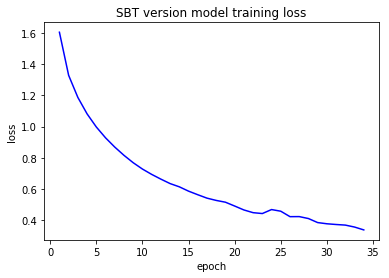

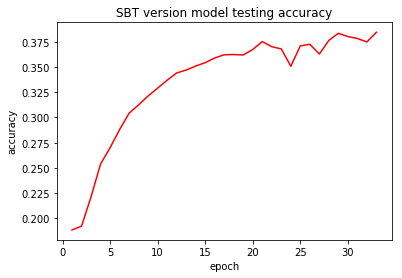

In [9]:
plt.plot(range(1, epoch+1), lossArray, "b")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title(MODE+" version model training loss")
plt.show()

plt.plot(range(1, epoch), testAccuracy, "r")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title(MODE+" version model testing accuracy")
plt.show()

## Restore the pre-trained model

In [10]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Evaluate the model via BLEU4

In [15]:
total_bleu = 0
for index, test in enumerate(test_inputs):
    predict = translate(test_inputs[index], encoder, decoder, code_voc, comment_voc, max_length_inp, max_length_targ, MODE)
    bleu_score = bleu(test_outputs[index], predict, 3)
    total_bleu += bleu_score
    if (index%1000) == 0:
        print(index)
        
total_bleu = total_bleu / len(test_inputs)
print("bleu3:",round(total_bleu, 4))

f_parameter = open(checkpoint_dir+"/parameters", "a")
f_parameter.write("BLEU3="+str(round(total_bleu, 4))+"\n")
f_parameter.close()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
bleu3: 0.3029


## Generate the comment of one snippet

In [35]:
index = 18
print(test_inputs[index], end="\n")
print("Original comment: ",test_outputs[index], end="\n")
predict = translate(test_inputs[index], encoder, decoder, code_voc, comment_voc, max_length_inp, max_length_targ, MODE)
print("Predicted translation: ", predict, end="\n")
bleu4_score = bleu(test_outputs[index], predict, 4)
print("bleu4: {:.4f}".format(bleu4_score), end="\n")

@Override public String printCheckStats(){
  StringBuilder sb=new StringBuilder("Permission Check Statistics:\n");
  checkStats.entrySet().stream().sorted(Map.Entry.comparingByValue()).forEachOrdered(null);
  String stats=sb.toString();
  log.trace(stats);
  return stats;
}

Original comment:  Print the permission check statistics
Predicted translation:  Output a Process 
bleu4: 0.0000


In [64]:
tf.test.is_gpu_available()

True